# Cat and Dog Image Classifier

In this project, the goal was to make a CNN to classify images of cats and dogs and get at least **63% accuracy**.

The original project was made with TensorFlow/Keras, but in this notebook I will use PyTorch because I prefer it. I also will adapt some of the code to fit better what i'm doing.

You can see the original solution [here]("https://colab.research.google.com/drive/1_ck5d7UQjM_o2a6WMl96hrXid-S9DWr8?usp=sharing").

---

In [6]:
# Import required libraries
import torch
import torchvision

import os
import requests
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [51]:
# Get project files
data_path = Path('data')
image_path = data_path / 'cats_and_dogs'

if image_path.is_dir():
    print("Directory already exists, skipping download")
else:
    print("Creating directory and downloading data...")
    data_path.mkdir(exist_ok=True, parents=True)

    with open(data_path / 'cats_and_dogs.zip', 'wb') as f:
        request = requests.get("https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip")
        print("Downloading cats and dogs images")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "cats_and_dogs.zip", 'r') as zip_ref:
        print("Unzipping cats and dogs data")
        zip_ref.extractall(data_path)

    os.remove(data_path / 'cats_and_dogs.zip')

Creating directory and downloading data...
Unzipping cats and dogs data


In [52]:
# Set key variables
train_dir = os.path.join(image_path, 'train')
validation_dir = os.path.join(image_path, 'validation')
test_dir = os.path.join(image_path, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [53]:
# Visualize
total_train, total_val, total_test

(2001, 1001, 51)

In [54]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

# Create the transformer
data_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor()
])

# Create Dataloaders and Datasets
train_data = ImageFolder(
    root=train_dir,
    transform=data_transform
)

val_data = ImageFolder(
    root=validation_dir,
    transform=data_transform
)

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    num_workers=os.cpu_count(),
    shuffle=True
)

val_dataloader = DataLoader(
    dataset=val_data,
    batch_size=batch_size,
    num_workers=os.cpu_count(),
    shuffle=False
)

len(train_dataloader), len(val_dataloader)

(16, 8)

In [68]:
class_names = train_data.classes
train_data, val_data, class_names

(Dataset ImageFolder
     Number of datapoints: 2000
     Root location: data\cats_and_dogs\train
     StandardTransform
 Transform: Compose(
                Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1000
     Root location: data\cats_and_dogs\validation
     StandardTransform
 Transform: Compose(
                Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ),
 ['cats', 'dogs'])

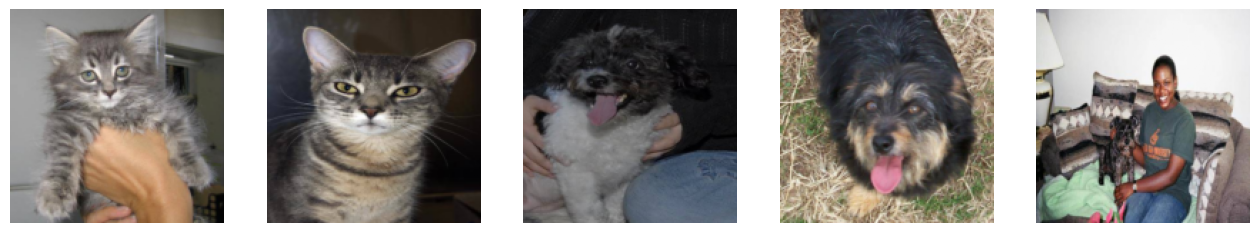

In [64]:
import random

def plotImages(dataset: torch.utils.data.Dataset, n: int):
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16,8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)


plotImages(train_data, 5)

In [62]:
# Recreate train dataloader with more transforms to not overfit
train_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])

train_data_augmented = ImageFolder(
    root=train_dir,
    transform=train_transforms,
)

train_dataloader_augmented = DataLoader(
    dataset=train_data_augmented,
    batch_size=batch_size,
    num_workers=os.cpu_count(),
    shuffle=True
)

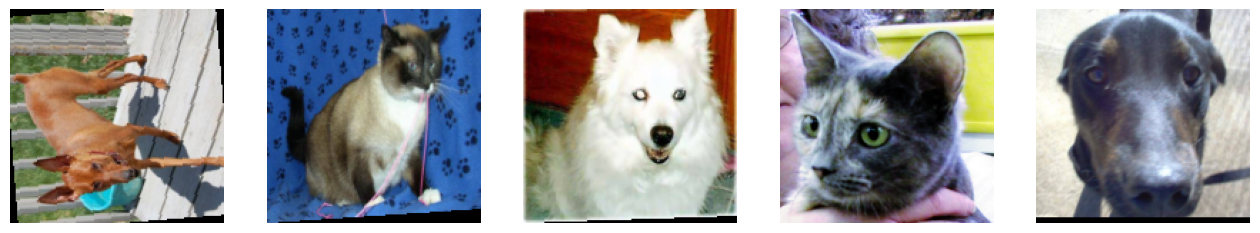

In [65]:
plotImages(train_data_augmented, 5)

In [72]:
from torch import nn

# Mimicking the TinyVGG architecture
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*34*34, out_features=output_shape)
        )


    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [67]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [73]:
model = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)
model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=11560, out_features=2, bias=True)
  )
)

In [74]:
# Testing to correct the last layer
image_batch, label_batch = next(iter(train_dataloader_augmented))
model(image_batch.to(device))

tensor([[-0.0865, -0.0493],
        [-0.1016, -0.0469],
        [-0.1019, -0.0491],
        [-0.0829, -0.0525],
        [-0.0905, -0.0539],
        [-0.1023, -0.0586],
        [-0.1049, -0.0521],
        [-0.0966, -0.0357],
        [-0.0953, -0.0535],
        [-0.0869, -0.0487],
        [-0.0989, -0.0505],
        [-0.0902, -0.0509],
        [-0.0999, -0.0450],
        [-0.1071, -0.0382],
        [-0.0866, -0.0557],
        [-0.0976, -0.0494],
        [-0.0986, -0.0569],
        [-0.1227, -0.0393],
        [-0.0883, -0.0567],
        [-0.1181, -0.0409],
        [-0.1007, -0.0412],
        [-0.0991, -0.0512],
        [-0.0941, -0.0481],
        [-0.1053, -0.0431],
        [-0.0968, -0.0494],
        [-0.0940, -0.0571],
        [-0.0984, -0.0445],
        [-0.0981, -0.0533],
        [-0.0963, -0.0532],
        [-0.0941, -0.0442],
        [-0.1006, -0.0460],
        [-0.0883, -0.0523],
        [-0.0969, -0.0463],
        [-0.0933, -0.0450],
        [-0.0936, -0.0564],
        [-0.0958, -0

In [71]:
image_batch.shape

torch.Size([128, 3, 150, 150])